In [56]:
!pip install optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [57]:
# Load Data
df = pd.read_csv("/content/gold_monthly_csv.csv", parse_dates=["Date"], index_col="Date")

In [58]:
# Feature Engineering
df["DayOfWeek"] = df.index.dayofweek
df["Quarter"] = df.index.quarter
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)
df["Month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df["Month_cos"] = np.cos(2 * np.pi * df.index.month / 12)
df["Lag_1"] = df["Price"].shift(1)
df["Lag_7"] = df["Price"].shift(7)
df["Lag_30"] = df["Price"].shift(30)
df["EWMA_7"] = df["Price"].ewm(span=7).mean()
df.dropna(inplace=True)

In [59]:
# Data Preprocessing & Scaling
scaler_lstm = MinMaxScaler()
scaler_tree = StandardScaler()
df_scaled_lstm = scaler_lstm.fit_transform(df)
df_scaled_tree = scaler_tree.fit_transform(df)

In [60]:
# Splitting Data
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
X_train, y_train = train.drop(columns=["Price"]), train["Price"]
X_test, y_test = test.drop(columns=["Price"]), test["Price"]
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
X_test_scaled_lstm = scaler_lstm.transform(X_test)
X_train_scaled_tree = scaler_tree.fit_transform(X_train)
X_test_scaled_tree = scaler_tree.transform(X_test)

In [61]:
# Walk-Forward Validation for LSTM
def walk_forward_validation(model, generator, test_data):
    predictions = []
    for i in range(len(test_data) - generator.length):
        x_input = test_data[i : i + generator.length]
        x_input = x_input.reshape((1, generator.length, X_train.shape[1]))
        yhat = model.predict(x_input, verbose=0)
        predictions.append(yhat[0, 0])
    return np.array(predictions)

In [62]:
# Hyperparameter Optimization for XGBoost
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_scaled_tree, y_train)
    preds = model.predict(X_test_scaled_tree)
    return mean_absolute_error(y_test, preds)

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=20)
best_params_xgb = study_xgb.best_params
xgb_model = xgb.XGBRegressor(**best_params_xgb)
xgb_model.fit(X_train_scaled_tree, y_train)

[I 2025-03-05 03:58:02,883] A new study created in memory with name: no-name-620a86ed-515d-4a66-a7f0-bfffeb14c706
<ipython-input-62-1388d3317f45>:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-62-1388d3317f45>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-62-1388d3317f45>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2025-03-05 03:58:03,002] Trial 0 finished with value: 740.6346838661752 and parameters: {'n_estimators': 84, 'learning_rate': 0.022214310142907923, 'max_depth': 4, 'subsample': 0.55798522557616

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9655857220337042, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1922546732069278, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=171, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [63]:
# LSTM Model with Early Stopping
sequence_length = 10
generator = TimeseriesGenerator(X_train_scaled_lstm, y_train, length=sequence_length, batch_size=16)
lstm_model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
    Dropout(0.2),
    GRU(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_model.fit(generator, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - loss: 84540.8672
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 76694.1875
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 71815.6094
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 69088.0938
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 84441.3516
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 60375.4453
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 64818.7109
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 96136.9844
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 67187.0859
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 61078.7695
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 67325.3594
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 69846.2734
Epoch 13/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 52085.1055
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 62566.1289
Epoch 15/20
41/41 ━━━━━━━

In [64]:
# Predictions
xgb_pred = xgb_model.predict(X_test_scaled_tree)
lstm_pred = walk_forward_validation(lstm_model, generator, X_test_scaled_lstm)

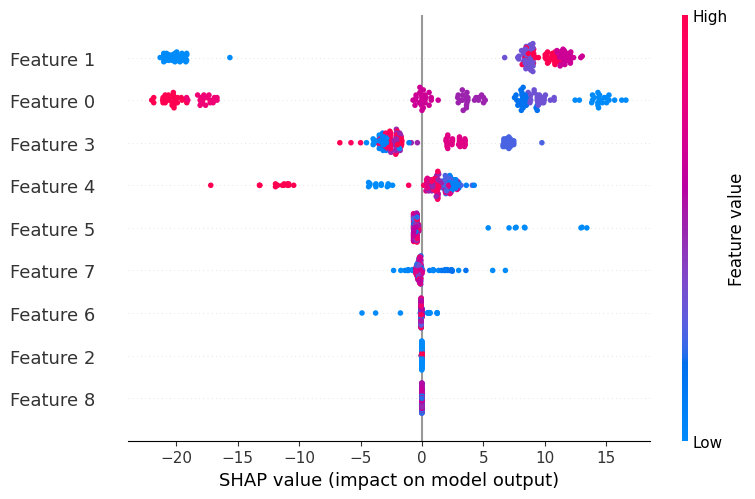

In [65]:
# SHAP Interpretability
explainer = shap.Explainer(xgb_model, X_test_scaled_tree)
shap_values = explainer(X_test_scaled_tree)
shap.summary_plot(shap_values, X_test_scaled_tree)

# Visualization
fig = px.line(df, x=df.index, y="Price", title="Time Series Data")
fig.add_trace(go.Scatter(x=df.index[train_size:], y=ensemble_pred, mode='lines', name='Predicted'))
fig.show()

In [66]:
# Save Models
import datetime
version = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(xgb_model, f"xgb_model_{version}.pkl")
lstm_model.save(f"lstm_model_{version}.h5")